# Demonstrating alignment transforms between Connectors, including dihedral angle setting

[19:50:53] UFFTYPER: Unrecognized atom type: *_ (8)
[19:50:53] UFFTYPER: Unrecognized atom type: *_ (11)
[19:50:53] UFFTYPER: Unrecognized atom type: *_ (0)


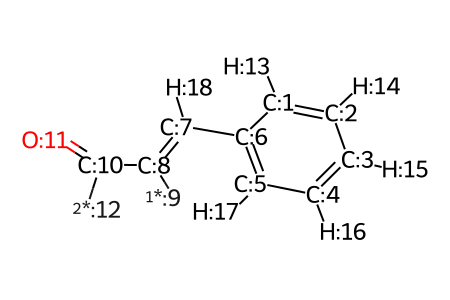

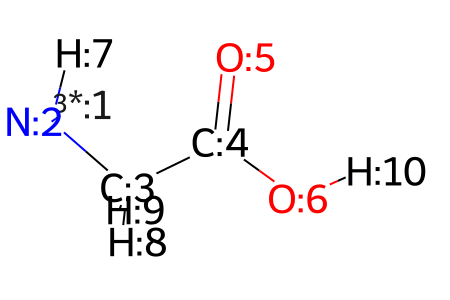

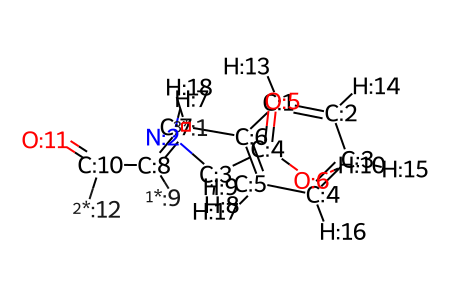

In [3]:
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule

from rdkit.Chem.Draw import IPythonConsole
aspect : float = 3/2
dim    : int = 300
IPythonConsole.molSize = (int(aspect*dim), dim)


def assign_sequential_map_nums(mol : Chem.Mol) -> None:
    for i, atom in enumerate(mol.GetAtoms(), start=1): # must start at 1, since map number 0 is not mapped
        atom.SetAtomMapNum(i)
        
def explicit_mol(smiles : str) -> tuple[Chem.Mol, int]:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    Chem.SanitizeMol(mol)

    assign_sequential_map_nums(mol)
    conf_id = EmbedMolecule(mol)
    
    return mol, conf_id

# mol1 = explicit_mol('c1c(-[1*])cccc1C=*C(=O)[2*]')
mol1, mol1_conf_idx = explicit_mol('c1ccccc1C=C(-[1*])C(=O)[2*]')
mol2, mol2_conf_idx = explicit_mol('[3*][NH]CC(=O)O')

mols = {
    'cinnamic acid' : mol1,
    'glycine'       : mol2,
}
for name, mol in mols.items():
    display(mol)
    for atom in mol.GetAtoms():
        atom.SetProp('molFileAlias', f'{name.replace(" ", "_")}_A{atom.GetIdx()}')
    
combo_mol = Chem.CombineMols(*mols.values())
display(combo_mol)
# with Chem.SDWriter('test.sdf') as writer:
#     writer.write(combo_mol, confId=0)

In [4]:
from mupt.mupr.connection import Connector
from mupt.interfaces.rdkit import connectors_from_rdkit


conn1 = list(connectors_from_rdkit(mol1, conformer_idx=0))[1]
conn2 = list(connectors_from_rdkit(mol2, conformer_idx=0))[0]

print(conn1)
print(conn2)

# dihedral_angle : float = np.pi/3
dihedral_angle : float = 0.0

conn2_trans = conn2.antialigned_rigidly_to(conn1, dihedral_angle_rad=dihedral_angle, match_bond_length=False)
conn2_trans_matched = conn2.antialigned_rigidly_to(conn1, dihedral_angle_rad=dihedral_angle, match_bond_length=True)
conn2_actual = list(connectors_from_rdkit(mol2, conformer_idx=0))[0]

print('==')
print(conn2)
print(conn2_actual)
print(conn2_trans)
print(conn2_trans_matched)

Connector(anchor=9, linkables={11}, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, label='Conn', anchor_position=array([-3.5045917 , -0.3164665 ,  0.01968676]), linker_position=array([-3.86718116, -1.44892145, -0.18898362]), bond_length=np.float64(1.2072566594821694), dihedral_plane_set=True)
Connector(anchor=1, linkables={0}, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, label='Conn', anchor_position=array([-1.65481077,  0.39006581, -0.29712728]), linker_position=array([-1.30943906,  0.63324038, -1.27664018]), bond_length=np.float64(1.0667056781246709), dihedral_plane_set=True)
==
Connector(anchor=1, linkables={0}, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, label='Conn', anchor_position=array([-1.65481077,  0.39006581, -0.29712728]), linker_position=array([-1.30943906,  0.63324038, -1.27664018]), bond_length=np.float64(1.0667056781246709), dihedral_plane_set=True)
Connector(anchor=1, linkables={0}, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, label='Conn', anchor_position=array([-1.6548107

In [5]:
import numpy as np
from scipy.spatial.transform import Slerp, Rotation, RigidTransform
from rdkit.Chem.rdMolTransforms import TransformConformer


n_steps_rotate : int = 50
n_steps_translate : int = 50
n_steps_dihedral : int = 100


# calculate and apply transform
## extract initial positions and match bond length before transforming
init_conf : Chem.Conformer = mol2.GetConformer(mol2_conf_idx)
### match bond length
conn2.set_bond_length(conn1.bond_length) 
init_conf.SetAtomPosition(conn2.linker, conn2.linker_position)
init_positions : np.ndarray = init_conf.GetPositions()

alignment = conn2.rigid_antialignment_to(conn1, tare_dihedrals=True)
translation, rotation = alignment.translation, alignment.rotation

## interpolate first rotation and then translation fo alignment
rotate_domain = np.linspace(0.0, 1.0, num=n_steps_rotate)
translate_domain = np.linspace(0.0, 1.0, num=n_steps_translate)

slerp = Slerp([0.0, 1.0], Rotation.concatenate([Rotation.identity(), rotation]))
turns : list[RigidTransform] = [
    RigidTransform.from_rotation(partial_rot)
       for partial_rot in slerp(rotate_domain)
]
shifts : list[RigidTransform] = [
    RigidTransform.from_components(
        translation=partial_translation,
        rotation=rotation
    )
        for partial_translation in np.outer(translate_domain, translation)
]


In [6]:
from pathlib import Path

alignment_dir = Path('alignments')
alignment_dir.mkdir(exist_ok=True)

# write series of intermediate transforms to SDF
rigid_align_path = alignment_dir / 'rigid_alignment.sdf'
with Chem.SDWriter(rigid_align_path) as writer:
    ## interpolate initial transform to dihedral of 0 radians
    for partial_alignment in RigidTransform.concatenate([*turns, *shifts]):
        # conn2.rigidly_transform(transformation=partial_alignment)
        mol2.GetConformer(mol2_conf_idx).SetPositions(
            partial_alignment.apply(init_positions)
        )
        writer.write(Chem.CombineMols(mol1, mol2), confId=0)
    conn2.antialign_rigidly_to(conn1, match_bond_length=True, tare_dihedrals=True)

    ## sweep through a full turn of dihedral angles
    for angle_rad in np.linspace(0, 2*np.pi, num=n_steps_dihedral):
        dihedral_alignment = conn2.dihedral_assignment_to(conn1, dihedral_angle_rad=angle_rad)
        conn2.rigidly_transform(transformation=dihedral_alignment)
        TransformConformer(mol2.GetConformer(mol2_conf_idx), dihedral_alignment.as_matrix())

        writer.write(Chem.CombineMols(mol1, mol2), confId=0)
    mol2.GetConformer(mol2_conf_idx).SetPositions(init_positions) # restore initial positions after interpolating

In [7]:
Connector.are_antialigned(conn1, conn2)

np.True_